In [1]:
!pip install biopython
!pip install chembl-webresource-client
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 66.8 MB/s eta 0:00:00


In [2]:
# Gerekli kütüphaneler: biopython, chembl_webresource_client, rdkit
from Bio import Entrez, SeqIO
import time
from chembl_webresource_client.new_client import new_client

# **NCBI üzerinden Lösemi ile ilgili olan ABL1 hedef proteinini çekiyoruz**

In [3]:
Entrez.email = "240542017@firat.edu.tr"
handle = Entrez.efetch(db="protein", id="NP_005148", rettype="fasta", retmode="text")
target_sequence = handle.read()
print("Hedef Protein İndirildi:", target_sequence[:50])

Hedef Protein İndirildi: >NP_005148.2 tyrosine-protein kinase ABL1 isoform 


In [4]:
with open("abl1_hedef_protein.fasta", "w") as f:
    f.write(target_sequence)

print("Başarılı! Hedef protein 'abl1_hedef_protein.fasta' olarak kaydedildi.")

Başarılı! Hedef protein 'abl1_hedef_protein.fasta' olarak kaydedildi.


<h1>Deleting duplicates for fasta file<h1/>

In [8]:
start = time.time()
seen = []
records = []
for record in SeqIO.parse("abl1_hedef_protein.fasta", "fasta"):
    if(str(record.seq) not in seen):
        seen.append(str(record.seq))
        records.append(record)
#Fasta dosyasını yeniden yazıyoruz.
SeqIO.write(records, "abl1_hedef_protein_tekrarsız.fasta", "fasta")
end = time.time()
print(f"Çalışma Süresi {(end- start)} saniye \n Yeni fasta dosyası 'abl1_hedef_protein_tekrarsız.fasta' adı ile kaydedildi")

Çalışma Süresi 0.0023555755615234375 saniye 
 Yeni fasta dosyası 'abl1_hedef_protein_tekrarsız.fasta' adı ile kaydedildi


In [9]:
# 2. ChEMBL'den Bu Hedefe Uygun İlaçları Bul
target = new_client.target
target_query = target.filter(target_synonym__icontains='ABL1').filter(target_organism__icontains='Homo sapiens')
target_id = target_query[0]['target_chembl_id']

activity = new_client.activity
res = activity.filter(target_chembl_id=target_id).filter(standard_type="IC50")

# İlaçların SMILES kodlarını topla
smiles_list = [x['canonical_smiles'] for x in res if x['canonical_smiles']]
print(f"{len(smiles_list)} adet potansiyel molekül bulundu.")

5287 adet potansiyel molekül bulundu.


In [10]:
import pandas as pd

# 1. Listeyi DataFrame'e (Tabloya) çevir
df = pd.DataFrame(smiles_list, columns=['SMILES'])

# 2. CSV dosyası olarak kaydet
df.to_csv('abl1_ilac_verisi.csv', index=False)

print(f"Başarılı! {len(df)} adet molekül 'abl1_ilac_verisi.csv' dosyasına kaydedildi.")

Başarılı! 5287 adet molekül 'abl1_ilac_verisi.csv' dosyasına kaydedildi.


In [11]:
def canonicalize_smiles(smiles):
  try:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
      return Chem.MolToSmiles(mol, canonical=True)
    else:
      return None # Geçersiz SMILES ise boş dön
  except:
      return None

# 2. İşlemi Uygula
print(f"Başlangıçtaki veri sayısı: {len(df)}")

# 'Canonical_SMILES' adında yeni bir sütun oluşturuyoruz
df['Canonical_SMILES'] = df['SMILES'].apply(canonicalize_smiles)

# 3. Geçersiz (None) olanları at (Bazen veritabanında hatalı kayıtlar olabilir)
df = df.dropna(subset=['Canonical_SMILES'])

# 4. ŞİMDİ kopyaları sil (Canonical sütununa göre)
df_clean = df.drop_duplicates(subset=['Canonical_SMILES'])

print(f"Temizlendikten sonraki veri sayısı: {len(df_clean)}")

# Temiz veriyi kullanalım
df_clean.to_csv('abl1_ilac_verisi_clean.csv', index=False)

Başlangıçtaki veri sayısı: 5287
Temizlendikten sonraki veri sayısı: 0


In [12]:
df_clean

,SMILES,Canonical_SMILES


In [13]:
# Modelin ürettiği çıktıyı analiz etme ve eleme kısmı (Organ yetmezliği kısıtı)
from rdkit import Chem
from rdkit.Chem import Descriptors, QED

def check_drug_quality(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return False

    # 1. QED (Quantitative Estimation of Drug-likeness)
    # Bu skor ilacın genel olarak vücutta emilip emilemeyeceğini tahmin eder.
    qed_score = QED.qed(mol)

    # 2. Moleküler Ağırlık (Çok ağırsa böbreklerden atılamaz)
    mw = Descriptors.MolWt(mol)

    # Filtre: İlaç benzeri olsun VE çok ağır olmasın (Basit bir toksisite önlemi)
    if qed_score > 0.5 and mw < 500:
        return True, f"Molekül uygun. QED: {qed_score:.2f}, MW: {mw:.1f}"
    else:
        return False, "Uygunsuz."

# Örnek Kullanım
generated_molecule = "CCC1(c2ccc(N)cc2)CCC(=O)NC1=O" # (Imatinib benzeri bir yapı)
is_good, reason = check_drug_quality(generated_molecule)
print(reason)

Molekül uygun. QED: 0.60, MW: 232.3


This is <span style="background-color: #FFFF00; padding: 2px 5px; border-radius: 3px;">highlighted text</span> in Colab.

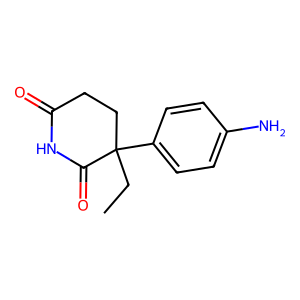

In [15]:
from  rdkit  import  Chem
from  rdkit.Chem  import  Draw

mol  =  Chem.MolFromSmiles("CCC1(c2ccc(N)cc2)CCC(=O)NC1=O")
Draw.MolToImage(mol)